In [26]:
import Pkg; 

Pkg.add("CSV") # install CSV
Pkg.add("DataFrames") # install Dataframes
Pkg.add("TimeSeries")
Pkg.add("Pandas")
Pkg.add("Plots") # plotting dataframe
Pkg.add("PyCall")
Pkg.add("RollingFunctions") # rolling functions

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

In [27]:
# import libraries
using CSV;
using Dates;
using DataFrames;
using Statistics;
using Plots;
using PyCall;
using RollingFunctions;

@pyimport matplotlib.pyplot as plt

In [16]:
# load data
df = CSV.File("../../database/hkex_ticks_day/hkex_0001.csv") |> DataFrame

first(df,5)

,Date,Open,High,Low,Close,Volume
,Date,Float64,Float64,Float64,Float64,Int64
1,2000-01-04,33.0375,33.3678,32.3767,32.3767,3194413
2,2000-01-05,30.89,31.3856,29.9815,30.1467,6058531
3,2000-01-06,30.3945,30.5596,28.0818,28.66,10440480
4,2000-01-07,29.073,29.4033,28.5774,29.2381,6049796
5,2000-01-10,30.2293,30.7248,29.4859,29.4859,5195405


### Building trading strategy

In [17]:
signals = df[:,[:Date, :Close]]

dates = Array(convert(Matrix, select(df, :Date))) # get dates
close = convert(Matrix, select(df, :Close)) # get closing price

first(signals,5)

,Date,Close
,Date,Float64
1,2000-01-04,32.3767
2,2000-01-05,30.1467
3,2000-01-06,28.66
4,2000-01-07,29.2381
5,2000-01-10,29.4859


In [18]:
# short MA
short_window = 40
short_mavg = runmean(vec(close), short_window)
insertcols!(signals, 1, :short_mavg => short_mavg)

first(signals, 5)

,short_mavg,Date,Close
,Float64,Date,Float64
1,32.3767,2000-01-04,32.3767
2,31.2617,2000-01-05,30.1467
3,30.3945,2000-01-06,28.66
4,30.1054,2000-01-07,29.2381
5,29.9815,2000-01-10,29.4859


In [19]:
# long MA
long_window = 100
long_mavg = runmean(vec(close), long_window)
insertcols!(signals, 1, :long_mavg => long_mavg)

first(signals, 5)

,long_mavg,short_mavg,Date,Close
,Float64,Float64,Date,Float64
1,32.3767,32.3767,2000-01-04,32.3767
2,31.2617,31.2617,2000-01-05,30.1467
3,30.3945,30.3945,2000-01-06,28.66
4,30.1054,30.1054,2000-01-07,29.2381
5,29.9815,29.9815,2000-01-10,29.4859


In [20]:
# create signals
signal = Float64[]
        
for i in 1:length(short_mavg)
    if short_mavg[i] > long_mavg[i]
        x = 1.0
    else
        x = 0.0
    end
    push!(signal, x)
end

insertcols!(signals, 1, :signal => signal)

first(signals, 5)

,signal,long_mavg,short_mavg,Date,Close
,Float64,Float64,Float64,Date,Float64
1,0.0,32.3767,32.3767,2000-01-04,32.3767
2,0.0,31.2617,31.2617,2000-01-05,30.1467
3,0.0,30.3945,30.3945,2000-01-06,28.66
4,0.0,30.1054,30.1054,2000-01-07,29.2381
5,0.0,29.9815,29.9815,2000-01-10,29.4859


In [21]:
# Generate positions
function gen_pos(signal)
    positions = zeros(length(signal))
    positions[1] = 0
    for i in 2:length(signal)
        positions[i] = signal[i] - signal[i-1]
    end
    return positions
end

positions = gen_pos(signal)

insertcols!(signals, 1, :positions => positions)
first(signals, 5)

,positions,signal,long_mavg,short_mavg,Date,Close
,Float64,Float64,Float64,Float64,Date,Float64
1,0.0,0.0,32.3767,32.3767,2000-01-04,32.3767
2,0.0,0.0,31.2617,31.2617,2000-01-05,30.1467
3,0.0,0.0,30.3945,30.3945,2000-01-06,28.66
4,0.0,0.0,30.1054,30.1054,2000-01-07,29.2381
5,0.0,0.0,29.9815,29.9815,2000-01-10,29.4859


In [23]:
# Generate tmp arrays to plot buy signals

buy_signals = DataFrame()
buy_dates = []
buy_prices = []

for i in 1:length(positions)
    if (positions[i] == 1.0)
       push!(buy_dates, dates[i])
       push!(buy_prices, close[i])
    end
end

insertcols!(buy_signals, 1, :Date => buy_dates)
insertcols!(buy_signals, 1, :Price => buy_prices)
first(buy_signals,10)

,Price,Date
,Any,Any
1,34.5241,2000-02-29
2,31.7059,2000-08-03
3,33.6644,2001-01-02
4,29.5685,2001-06-15
5,25.8272,2001-11-28
6,26.1597,2002-05-24
7,19.7127,2002-12-09
8,18.7929,2003-06-16
9,27.0499,2004-01-16


In [24]:
# Generate tmp arrays to plot sell signals

sell_signals = DataFrame()
sell_dates = []
sell_prices = []

for i in 1:length(positions)
    if (positions[i] == -1.0)
       push!(sell_dates, dates[i])
       push!(sell_prices, close[i])
    end
end

insertcols!(sell_signals, 1, :Date => sell_dates)
insertcols!(sell_signals, 1, :Price => sell_prices)
first(sell_signals,10)

,Price,Date
,Any,Any
1,27.5037,2000-05-08
2,29.4352,2000-10-27
3,27.236,2001-03-23
4,27.4133,2001-07-20
5,22.6097,2002-03-01
6,23.4904,2002-07-12
7,18.3625,2003-01-31
8,22.9029,2003-12-26
9,23.9396,2004-04-19


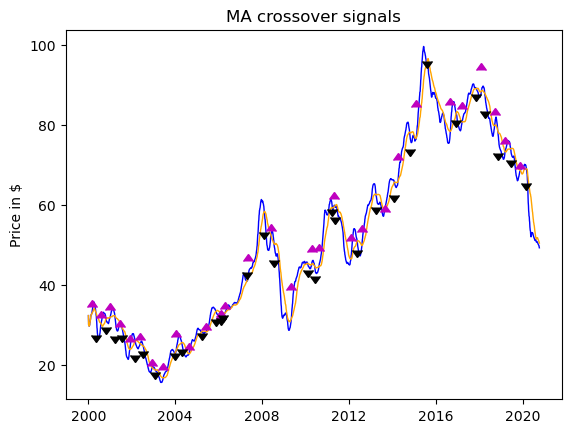

In [29]:
# Plot signals and MAs

fig = plt.figure() # Initialise the plot figure
ax1 = fig.add_subplot(111, ylabel="Price in \$") # Add a subplot and label for y-axis

plt.plot(signals.Date, signals.short_mavg, color="blue", linewidth=1.0, label="Short MA")
plt.plot(signals.Date, signals.long_mavg, color="orange", linewidth=1.0, label="Long MA")
#plt.plot(signals.Date, signals.Close, color="red", linewidth=0.8, label="Closing price")
plt.plot(buy_signals.Date, buy_signals.Price, marker=10, markersize=7, color="m", linestyle="None", label="Buy signal")
plt.plot(sell_signals.Date, sell_signals.Price, marker=11, markersize=7, color="k", linestyle="None", label="Sell signal")

plt.title("MA crossover signals")
plt.show()

# save fig
fig.savefig("./figures/moving-average-crossover_ma", dpi=100)

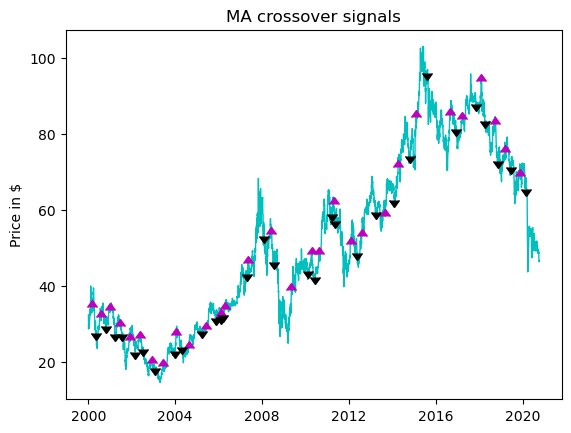

In [35]:
fig = plt.figure() # Initialise the plot figure
ax1 = fig.add_subplot(111, ylabel="Price in \$") # Add a subplot and label for y-axis

#plt.plot(signals.Date, signals.short_mavg, color="blue", linewidth=1.0, label="Short MA")
#plt.plot(signals.Date, signals.long_mavg, color="orange", linewidth=1.0, label="Long MA")
plt.plot(signals.Date, signals.Close, color="c", linewidth=1.0, label="Closing price")
plt.plot(buy_signals.Date, buy_signals.Price, marker=10, markersize=7, color="m", linestyle="None", label="Buy signal")
plt.plot(sell_signals.Date, sell_signals.Price, marker=11, markersize=7, color="k", linestyle="None", label="Sell signal")

plt.title("MA crossover signals")
plt.show()

# save fig
fig.savefig("./figures/moving-average-crossover_signals", dpi=100)